In [ ]:
!pip install keras-rl2
!pip install keras
!pip install tensorflow==2.3.0
!pip install gym

In [3]:
# import env class from gym to create custom environment
from gym import Env

# import two spaces from gym, allow us to define state and actions
from gym.spaces import Discrete, Box  
import numpy as np 
import pandas as pd
import random

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Read Dataset

In [5]:
data = pd.read_csv("/content/drive/My Drive/sample_data.csv")
weight = pd.DataFrame(data)

Simulate index for two malicious and three non-malicious clients

In [6]:
malicious_index = [0,1]
non_malicious_index = [2,3,4]

Define state, action and reward for RL agent

In [7]:
class findmeEnv(Env):
    STATE_ELEMENTS = 5

    def __init__(self, weight):
        self.weight = weight
        self.action_space = Discrete(5)
        self.observation_space = Box(low=0, high=2, shape=(findmeEnv.STATE_ELEMENTS,)) #10 comm.round, 5 clients
        self.state = self.weight.iloc[0:1].values
        self.state1 = self.weight.iloc[0:1]
        self.length = 100



    def step(self,action):
        if action==0:   #reward for this action is +2
            a = random.choice(malicious_index)
            self.state1.iloc[:,a].replace([self.state1.iloc[:,a]],0,inplace=True)
            
        if action==1: #reward for this action is -10
            b = random.choice(non_malicious_index)
            self.state1.iloc[:,b].replace([self.state1.iloc[:,b]],0,inplace=True)
  

        if action==2: #reward is +5
            self.state1.iloc[:,0].replace([self.state1.iloc[:,0]],0,inplace=True)
            self.state1.iloc[:,1].replace([self.state1.iloc[:,1]],0,inplace=True)
            

        if action==3: #reward is +1
            x = random.choice(malicious_index)
            y = random.choice(non_malicious_index)
            self.state1.iloc[:,x].replace([self.state1.iloc[:,x]],0,inplace=True)
            self.state1.iloc[:,y].replace([self.state1.iloc[:,y]],0,inplace=True)
            


        if action==4: #reward is -15
            self.state1.iloc[:,2].replace([self.state1.iloc[:,2]],0,inplace=True)
            self.state1.iloc[:,3].replace([self.state1.iloc[:,3]],0,inplace=True)
            self.state1.iloc[:,4].replace([self.state1.iloc[:,4]],0,inplace=True)

        self.length -= 1


        # Defind reward value 
        if action==0:
            reward = 2
        if action==1:
            reward = -10
        if action == 2:
            reward = 5
        if action==3:
            reward = 1
        if action==4:
            reward = -15


        if self.length <= 0: 
            done = True
        else:
            done = False

        info = {}
        return self.state, reward, done, info

    def reset(self):
        self.state = self.weight.sample().reset_index(drop = True).values
        self.state = np.squeeze(self.state, axis=0)
        self.length = 100
        return self.state
        

Instantiate the RL environment 

In [8]:
env = findmeEnv(weight)
# obs = env.reset()
# print(obs.shape)

Get shape of state and action

In [9]:
states = env.observation_space.shape 
actions = env.action_space.n 
actions 
states

(5,)

**CREATE A DEEP LEARNING MODEL WITH KERAS**


In [19]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import random 
import time

**Define model architecture**

In [20]:
def build_model(states,actions):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape = (1,5)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    model.add(Flatten())
    return model

In [ ]:
model = build_model(states,actions)
model.summary()

**Define DQN Agent and train it on the env**

In [65]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger


def build_agent(model, actions):
  policy = BoltzmannQPolicy()
  memory = SequentialMemory(limit=50000, window_length = 1)
  dqn = DQNAgent(model = model, memory = memory, policy=policy, nb_actions=actions, nb_steps_warmup = 10, target_model_update = 1e-2)
  return dqn


**Start training the agent on the given environment**

In [66]:
ENV_NAME = 'RL_IoT-v1'

In [67]:
def build_callbacks(ENV_NAME):
    checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(ENV_NAME)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    return callbacks

In [72]:
policy = BoltzmannQPolicy()
memory = SequentialMemory(limit=50000, window_length = 1)
dqn = DQNAgent(model=model, nb_actions=actions, policy=policy, memory=memory, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
                   train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])
callbacks = build_callbacks(ENV_NAME)

In [76]:
dqn.fit(env, nb_steps=100)

Training for 100 steps ...
Interval 1 (0 steps performed)
   94/10000 [..............................] - ETA: 22s - reward: 4.2979done, took 0.234 seconds


In [108]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
callbacks = build_callbacks(ENV_NAME)
dqn.fit(env, nb_steps=20000, visualize=False,verbose=2, callbacks=callbacks)
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

Training for 20000 steps ...


/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   100/20000: episode: 1, duration: 7.463s, episode steps: 100, steps per second:  13, episode reward: 500.000, mean reward:  5.000 [ 5.000,  5.000], mean action: 2.000 [2.000, 2.000],  loss: 0.111432, mae: 124.998340, mean_q: 261.242375
   200/20000: episode: 2, duration: 1.212s, episode steps: 100, steps per second:  83, episode reward: 455.000, mean reward:  4.550 [ 2.000,  5.000], mean action: 1.700 [0.000, 2.000],  loss: 198.838531, mae: 123.718750, mean_q: 256.469513
   300/20000: episode: 3, duration: 1.235s, episode steps: 100, steps per second:  81, episode reward: 488.000, mean reward:  4.880 [ 2.000,  5.000], mean action: 1.920 [0.000, 2.000],  loss: 252.117752, mae: 122.723282, mean_q: 257.169250
   400/20000: episode: 4, duration: 1.225s, episode steps: 100, steps per second:  82, episode reward: 500.000, mean reward:  5.000 [ 5.000,  5.000], mean action: 2.000 [2.000, 2.000],  loss: 245.438461, mae: 120.792557, mean_q: 257.878876
   500/20000: episode: 5, duration: 1.218s

In [ ]:
# dqn.load_weights("/content/drive/MyDrive/Colab Notebooks/RL_IoT_FL/dqn.h5f.data-00000-of-00001.h5f")

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

**Predict using model**

In [109]:
df = pd.read_json("/content/dqn_RL_IoT-v1_log.json")
# csvdata = df.to_csv()
# cs = pd.DataFrame(csvdata)
episode = df.loc[:,'episode']
mean_reward = df.loc[:,'episode_reward']
mean_reward
episode
df

,loss,mae,mean_q,episode_reward,nb_episode_steps,nb_steps,episode,duration
0,0.111432,124.998340,261.242375,500,100,100,0,7.462015
1,198.838577,123.718781,256.469482,455,100,200,1,1.211378
2,252.117767,122.723282,257.169250,488,100,300,2,1.234160
3,245.438492,120.792572,257.878876,500,100,400,3,1.224842
4,304.119659,118.783646,255.559906,500,100,500,4,1.217611
...,...,...,...,...,...,...,...,...
195,200.156555,112.005264,251.269333,500,100,19600,195,1.222101
196,357.732727,111.498352,249.262344,500,100,19700,196,1.226012
197,249.135406,111.673935,250.878464,500,100,19800,197,1.235112
198,377.540436,112.447929,249.805603,500,100,19900,198,1.246366


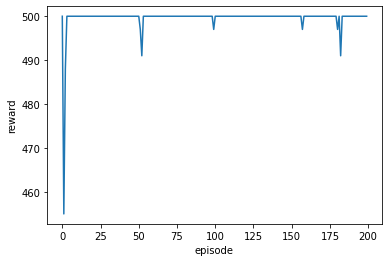

In [110]:
import matplotlib.pyplot as plt
plt.plot(episode,mean_reward)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()